# SR Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU


***Le code fourni au départ est celui pour faire la Super Résolution***

# Charger les bibliothèques

In [112]:
# Colab only
# download and install Pytorch

# ferdi 1

!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


In [113]:
import torch
torch.cuda.is_available()

True

In [114]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import math
import inspect  # debugage
import pandas as pd

# La Base de donnée

On a choisit de travailler avec CIFAR 10, des images RGB 32 par 32, avec 10 classes, 50000 données d'entrainement et 10000 données de test.


On a voulu au départ travailler avec la base de donnée CELEBA, mais celle si étant trop lourde, avec plus de 2000 classes, on s'est retrouvé face aux problèmes suivants :
- devoir charger les données prend beaucoup de temps (+ de 200000 images)
- le téléchargement devait se faire sur un lien drive qui autorisait un download par 24h
- google collab enregistre le code mais vide les fichiers entre chaque session, on a donc tout perdu après les efforts

On a choisit une solutions sans drive, pytorch offre directement un accès à la base de donnée CIFAR10, qu'on peut donc download a chaque session sans difficulté et rapidement (car plus légère).


In [115]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(trainset)

print(testset)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


On utilise une transformation pour normaliser les images $I \in [0, 1]^3$ de CIFAR-10 de façon à avoir $I_{norm} \in [-1, 1]^3$ :

$
I_{norm} = \frac{I - \mu}{\sigma}
$

d'ou $\mu = 0.5$ et $\sigma = 0.5$

La normalisation vise à centrer les valeurs autour de zéro et à les mettre à l'échelle de manière à avoir une variance relativement uniforme. Cela peut aider à stabiliser et à accélérer l'entraînement du modèle, en particulier lorsque vous utilisez des méthodes d'optimisation sensibles à l'échelle des données.

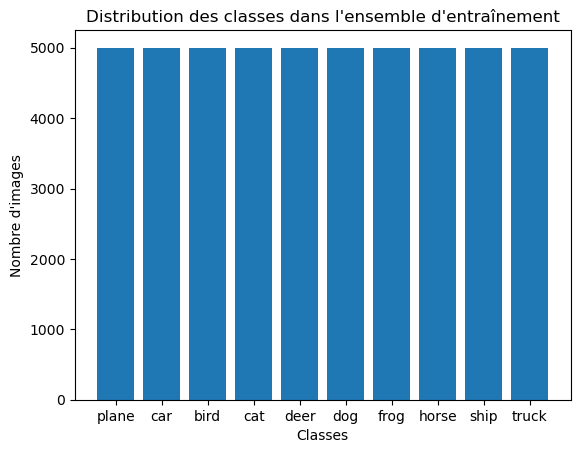

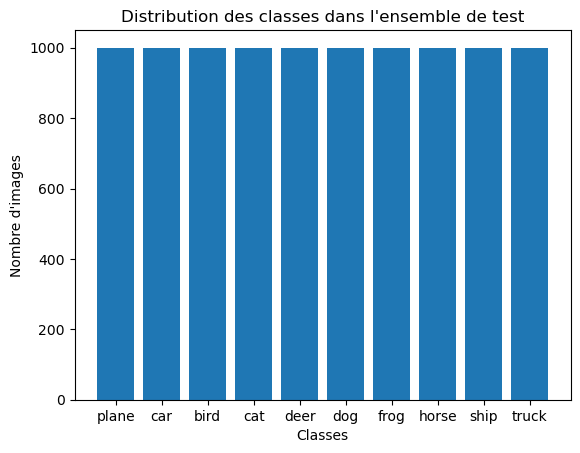

In [116]:
# Fonction pour afficher le nombre d'images par classe
def show_class_distribution(dataset, set_name):
    class_counts = [0] * len(classes)
    for _, label in dataset:
        class_counts[label] += 1

    fig, ax = plt.subplots()
    ax.bar(classes, class_counts)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Nombre d\'images')
    ax.set_title(f'Distribution des classes dans l\'ensemble {set_name}')
    plt.show()

# Afficher la distribution des classes dans l'ensemble d'entraînement
show_class_distribution(trainset, "d'entraînement")

# Afficher la distribution des classes dans l'ensemble de test
show_class_distribution(testset, "de test")

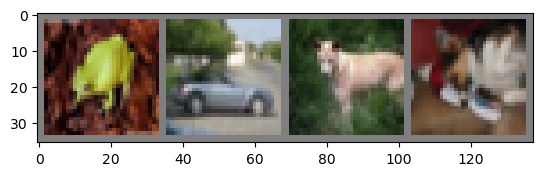

batch_size = 4 et dimension d'une image = torch.Size([3, 32, 32])
frog  car   dog   dog  


In [10]:
# afficher un batch : (cette case peut être run autant de fois qu'on veut)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)



# show images
imshow(torchvision.utils.make_grid(images))
print(f"batch_size = {images.shape[0]} et dimension d'une image = {images.shape[1:]}")
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Le modèle simple

Dans cette partie, on va suivre le tutoriel de classification de pytorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).


## Réseau simple :

Dans le tuto, on utilise la structure suivante :



In [12]:

class S_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ## conv1 puis pool :
        x = self.pool(F.relu(self.conv1(x)))
        ## conv2 puis pool :
        x = self.pool(F.relu(self.conv2(x)))
        ## flatten :
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        ## fully connected 1 :
        x = F.relu(self.fc1(x))
        ## fully connected 2 :
        x = F.relu(self.fc2(x))
        ## fully connected 3 :
        x = self.fc3(x)
        return x

    def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")


net = S_Net()
net = net.cuda()

net.size_debug(images.cuda())





in :
torch.Size([4, 3, 32, 32])
## conv1 puis pool :
torch.Size([4, 6, 14, 14])
## conv2 puis pool :
torch.Size([4, 16, 5, 5])
## flatten :
torch.Size([4, 400])
## fully connected 1 :
torch.Size([4, 120])
## fully connected 2 :
torch.Size([4, 84])
## fully connected 3 :
torch.Size([4, 10])
out.


## Réseau simple amélioré



In [134]:
class S_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)  # Ajout d'un dropout

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Ajout du dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x)  # Correction de la fonction log_softmax
        return x
    
    def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")


net = S_Net()
net = net.cuda()

net.size_debug(images.cuda())


in :
torch.Size([16, 3, 32, 32])
torch.Size([16, 32, 14, 14])
torch.Size([16, 64, 5, 5])
torch.Size([16, 1600])
torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16, 84])
torch.Size([16, 10])
torch.Size([16, 10])
out.


<string>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Optimisation et Calcul d'erreur


C:\Users\yacin\AppData\Local\Temp\ipykernel_26400\2549296333.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)  # Correction de la fonction log_softmax


[1, 8992] loss: 2.307
[1, 18016] loss: 2.302
[1, 27040] loss: 2.293
[1, 36064] loss: 2.276
[1, 45088] loss: 2.253
Accuracy of the network on the 10000 test images: 23.32 %
Accuracy of the network on the 50000 train images: 23.616 %
[2, 8992] loss: 2.207
[2, 18016] loss: 2.190
[2, 27040] loss: 2.173
[2, 36064] loss: 2.162
[2, 45088] loss: 2.139
Accuracy of the network on the 10000 test images: 35.94 %
Accuracy of the network on the 50000 train images: 35.422 %
[3, 8992] loss: 2.117
[3, 18016] loss: 2.105
[3, 27040] loss: 2.090
[3, 36064] loss: 2.078
[3, 45088] loss: 2.065
Accuracy of the network on the 10000 test images: 42.08 %
Accuracy of the network on the 50000 train images: 42.144 %
[4, 8992] loss: 2.054
[4, 18016] loss: 2.043
[4, 27040] loss: 2.027
[4, 36064] loss: 2.018
[4, 45088] loss: 2.012
Accuracy of the network on the 10000 test images: 46.7 %
Accuracy of the network on the 50000 train images: 47.674 %
[5, 8992] loss: 2.000
[5, 18016] loss: 1.993
[5, 27040] loss: 1.982
[5, 3

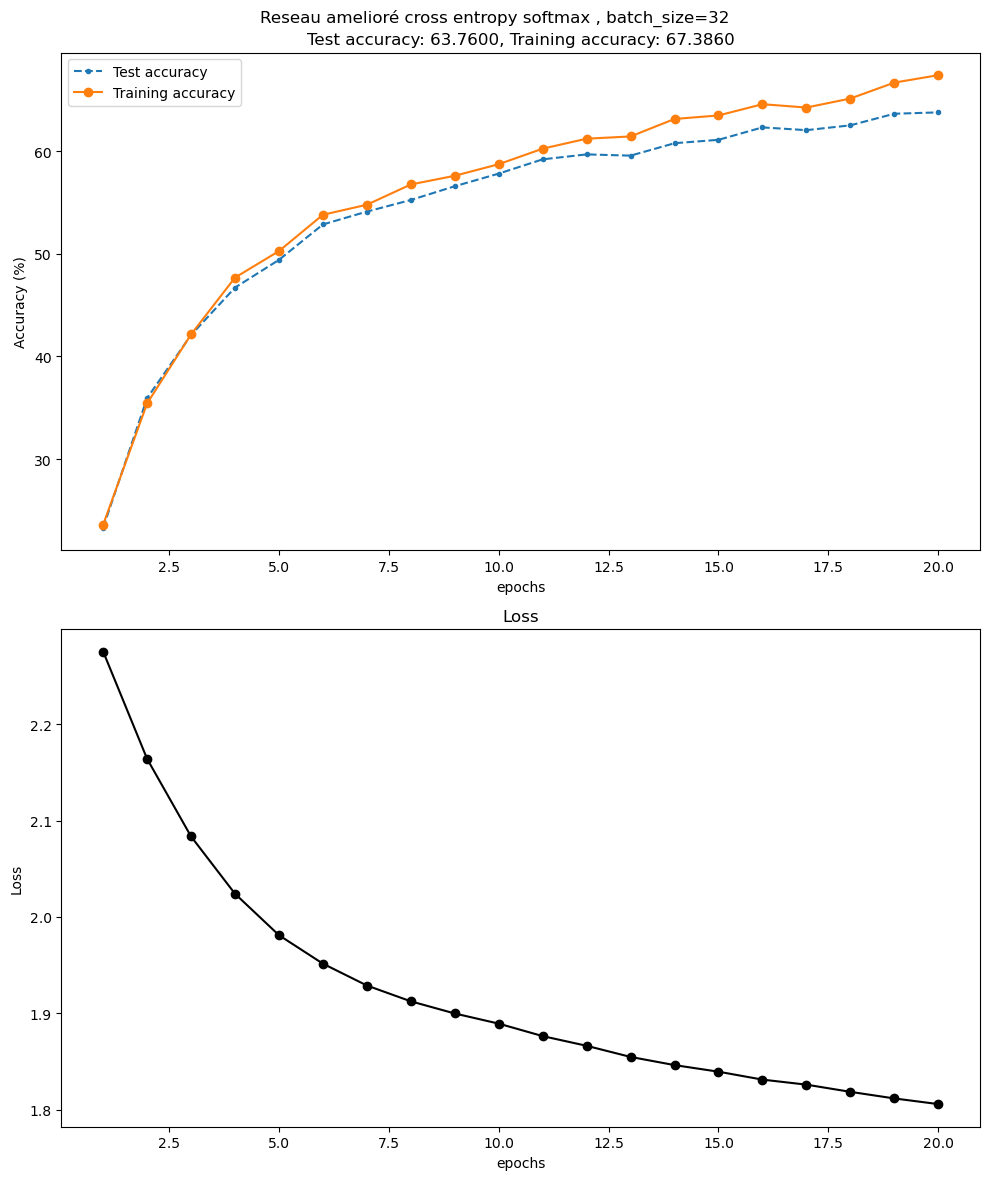

In [136]:
def mega_tout(
        net,
        criterion,
        optimizer,
        n_epochs,
        run_name
    ):


    LOSS = []
    accuracy_test = []
    accuracy_train = []


    for epoch in range(1, n_epochs+1):  # loop over the dataset multiple times


        running_loss = 0.0
        data_count = 0
        total_loss = 0.0
        for i, (data) in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()


            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            # print statistics
            running_loss += loss.item()
            total_loss += loss.item()
           
            data_count += batch_size
            if data_count >= 9000: # print every 9000 data
                    print(f'[{epoch}, {i * batch_size}] loss: {running_loss / 9000 * batch_size:.3f}')
                    data_count = 0
                    running_loss = 0.0


        LOSS.append(total_loss / len(trainset) * batch_size)
       
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total} %')
        accuracy_test.append(100 * correct / total)
       
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in trainloader:
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
       
        print(f'Accuracy of the network on the {len(trainset)} train images: {100 * correct / total} %')
        accuracy_train.append(100 * correct / total)
       
    print('Finished Training')
   
    # tester sur tout le test dataset :


   


    epochs = list(range(1, n_epochs+1))


    plt.figure(figsize=(10, 12))
    plt.suptitle(f"{run_name}, batch_size={batch_size}")


    plt.subplot(2, 1, 1)


    plt.plot(epochs, accuracy_test, ".--", label="Test accuracy")
    final_acc = accuracy_test[-1]
    title = "Test accuracy: {:.4f}".format(final_acc)
    plt.ylabel("Accuracy (%)")


    plt.plot(epochs, accuracy_train, "o-", label="Training accuracy")
    final_train_acc = accuracy_train[-1]
    title += ", Training accuracy: {:.4f}".format(final_train_acc)
    plt.title(title)


    plt.xlabel("epochs")
    plt.legend()


    plt.subplot(2,1,2)
    plt.plot(epochs, LOSS, 'o-k')
    plt.ylabel("Loss")
    plt.xlabel("epochs")
    plt.title("Loss")


    plt.tight_layout()




    name = f"{run_name}_bs_{batch_size}.png"
    plt.savefig(name, dpi=300, bbox_inches='tight')


net = S_Net()
net=net.cuda()
mega_tout(
    net,
    nn.CrossEntropyLoss(),
    optim.SGD(net.parameters(), lr=0.001, momentum=0.9),
    20,
    "Reseau amelioré cross entropy softmax "
)



## Evaluation du modèle :

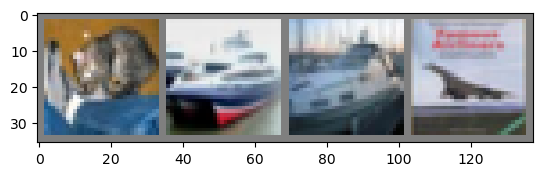

GroundTruth:  cat   ship  ship  plane
Predicted:  plane plane plane plane


In [17]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = S_Net()
net = net.cuda()
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


# Le Modèle PARKHI

In [183]:
# create the neural network with Pytorch
class P_Net(nn.Module):
  
  def __init__(self, in_channels, out_channels):
    
    super().__init__()

    self.in_channels = in_channels

    S = 32

    self.conv11 = nn.Conv2d(in_channels, S, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(S)
    self.conv12 = nn.Conv2d(S, S, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(S)

    self.conv21 = nn.Conv2d(S, 2*S, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(2*S)
    self.conv22 = nn.Conv2d(2*S, 2*S, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(2*S)

    self.conv31 = nn.Conv2d(2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(2*2*S)
    self.conv32 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(2*2*S)
    self.conv33 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(2*2*S)

    self.conv41 = nn.Conv2d(2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(2*2*2*S)
    self.conv42 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(2*2*2*S)
    self.conv43 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(2*2*2*S)

    self.conv51 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(2*2*2*S)
    self.conv52 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(2*2*2*S)
    self.conv53 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(2*2*2*S)

    self.fc6 = nn.Linear(in_features=2*2*2*S, out_features=4096)
    self.fc7 = nn.Linear(in_features=4096, out_features=4096)  
    self.fc8 = nn.Linear(in_features=4096, out_features=10)


  def forward(self, x):
                  ## Stage 1
    ## conv11 :
    x = F.relu(self.bn11(self.conv11(x)))
    ## conv12 :
    x = F.relu(self.bn12(self.conv12(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 2
    ## conv21 :
    x = F.relu(self.bn21(self.conv21(x)))
    ## conv22 :
    x = F.relu(self.bn22(self.conv22(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 3
    ## conv31 :
    x = F.relu(self.bn31(self.conv31(x)))
    ## conv32 :
    x = F.relu(self.bn32(self.conv32(x)))
    ## conv33 :
    x = F.relu(self.bn33(self.conv33(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 4
    ## conv41 :
    x = F.relu(self.bn41(self.conv41(x)))
    ## conv42 :
    x = F.relu(self.bn42(self.conv42(x)))
    ## conv43 :
    x = F.relu(self.bn43(self.conv43(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 5
    ## conv51 :
    x = F.relu(self.bn51(self.conv51(x)))
    ## conv52 :
    x = F.relu(self.bn52(self.conv52(x)))
    ## conv53 :
    x = F.relu(self.bn53(self.conv53(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    ## flatten :
    x = torch.flatten(x, 1)
                  ## Stage 6
    ## fully connected 6 :
    x = F.relu(self.fc6(x))
                  ## Stage 7
    ## fully connected 7 :
    x = F.relu(self.fc7(x))
                  ## Stage 8
    ## fully connected 8 :
    x = F.relu(self.fc8(x))

    return x
  
  def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")

# actual network creation
net = P_Net(3,3)
net.cuda() # go GPU

net.size_debug(images.cuda())

in :
torch.Size([4, 3, 32, 32])
## Stage 1
## conv11 :
torch.Size([4, 32, 32, 32])
## conv12 :
torch.Size([4, 32, 32, 32])
## maxpool :
torch.Size([4, 32, 16, 16])
## Stage 2
## conv21 :
torch.Size([4, 64, 16, 16])
## conv22 :
torch.Size([4, 64, 16, 16])
## maxpool :
torch.Size([4, 64, 8, 8])
## Stage 3
## conv31 :
torch.Size([4, 128, 8, 8])
## conv32 :
torch.Size([4, 128, 8, 8])
## conv33 :
torch.Size([4, 128, 8, 8])
## maxpool :
torch.Size([4, 128, 4, 4])
## Stage 4
## conv41 :
torch.Size([4, 256, 4, 4])
## conv42 :
torch.Size([4, 256, 4, 4])
## conv43 :
torch.Size([4, 256, 4, 4])
## maxpool :
torch.Size([4, 256, 2, 2])
## Stage 5
## conv51 :
torch.Size([4, 256, 2, 2])
## conv52 :
torch.Size([4, 256, 2, 2])
## conv53 :
torch.Size([4, 256, 2, 2])
## maxpool :
torch.Size([4, 256, 1, 1])
## flatten :
torch.Size([4, 256])
## Stage 6
## fully connected 6 :
torch.Size([4, 4096])
## Stage 7
## fully connected 7 :
torch.Size([4, 4096])
## Stage 8
## fully connected 8 :
torch.Size([4, 10])
ou

In [173]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # create the optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# criterion = F.mse_loss # ça marche pas ici parce que il faut criterion(outputs, labels) avec outputs et labels de meme size (pq ??)
# criterion = nn.CrossEntropyLoss()

In [1]:

n_epochs = 20

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    PATH = f"./cifar_net_parkhi_n_epochs={epoch+1}.pth"
    torch.save(net.state_dict(), PATH)
print('Finished Training')



NameError: name 'trainloader' is not defined

In [64]:
# save the model
PATH = f"./cifar_net_parkhi_n_epochs={n_epochs}.pth"
torch.save(net.state_dict(), PATH)

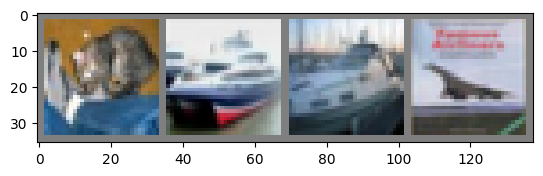

GroundTruth:  cat   ship  ship  plane
Predicted:  plane plane plane plane


In [73]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = NetP(3,3)
net.load_state_dict(torch.load(PATH))
#net.cuda()

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


In [74]:
# tester sur tout le test dataset :
err_test_park=[]
err_train_park=[]
for epoch in range(n_epochs):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    err_test_park.append(100 * correct // total)
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    err_train_park.append(100 * correct // total)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %
